# Exploratory Data Analysis
### Exploring the data of bike station, bike trips, and Toronto Weather

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import calendar

sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

trips_data = pd.read_csv('all_bike_trips.csv')
stations_data = pd.read_csv('all_bike_stations.csv')
weather_data = pd.read_csv('all_weather.csv')

## Exploring Bike Trips Data

In [2]:
# Explore Trips Data
# trips_data['End Time'] = pd.to_datetime(trips_data['End Time']).dt.tz_convert('America/Toronto')
# trips_data['Start Time'] = pd.to_datetime(trips_data['Start Time']).dt.tz_convert('America/Toronto')

trips_data.info()
trips_data.describe()
trips_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11052490 entries, 0 to 11052489
Data columns (total 10 columns):
 #   Column              Dtype 
---  ------              ----- 
 0   Trip Id             int64 
 1   Start Station Id    int64 
 2   Start Time          object
 3   Start Station Name  object
 4   End Station Id      int64 
 5   End Time            object
 6   End Station Name    object
 7   Bike Id             int64 
 8   User Type           object
 9   Trip Duration       int64 
dtypes: int64(5), object(5)
memory usage: 843.2+ MB


,Trip Id,Start Station Id,Start Time,Start Station Name,End Station Id,End Time,End Station Name,Bike Id,User Type,Trip Duration
0,26916635,7458,2024-02-01 00:00:00-05:00,Church St / Lombard St,7256,2024-02-01 00:15:00-05:00,Vanauley St / Queen St W - SMART,2325,Casual Member,897
1,26916636,7285,2024-02-01 00:02:00-05:00,Spadina Ave / Harbord St - SMART,7023,2024-02-01 00:06:00-05:00,College St / Borden St,623,Annual Member,267
2,26916637,7531,2024-02-01 00:02:00-05:00,541 Huron St - SMART,7058,2024-02-01 00:05:00-05:00,Huron/ Harbord St,7284,Annual Member,158
3,26916638,7027,2024-02-01 00:02:00-05:00,Beverley St / Dundas St W,7206,2024-02-01 00:08:00-05:00,Claremont St / Dundas St W,6595,Casual Member,357
4,26916639,7469,2024-02-01 00:02:00-05:00,Wellington St W / York St,7417,2024-02-01 00:05:00-05:00,King St W / Jordan St,357,Casual Member,195


### Number of trips

In [3]:
# Derive time features and normalize user types
trips = trips_data.copy()

trips['End Time'] = pd.to_datetime(trips['End Time']).dt.tz_convert('America/Toronto')
trips['Start Time'] = pd.to_datetime(trips['Start Time']).dt.tz_convert('America/Toronto')


# Time-based features
trips['date'] = trips['Start Time'].dt.date
trips['year'] = trips['Start Time'].dt.year
trips['month'] = trips['Start Time'].dt.month
trips['dayofweek'] = trips['Start Time'].dt.dayofweek  # 0=Mon
trips['hour'] = trips['Start Time'].dt.hour
trips['day'] = trips['Start Time'].dt.day
trips['year_month'] = trips['Start Time'].dt.to_period('M').dt.to_timestamp()

# Weekday labels
_dow_map = {0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thu', 4: 'Fri', 5: 'Sat', 6: 'Sun'}
trips['dow_name'] = trips['dayofweek'].map(_dow_map)

/var/folders/8k/klw6h73n6vbfxmtrqkgv_fmc0000gn/T/ipykernel_42667/3747001267.py:15: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  trips['year_month'] = trips['Start Time'].dt.to_period('M').dt.to_timestamp()


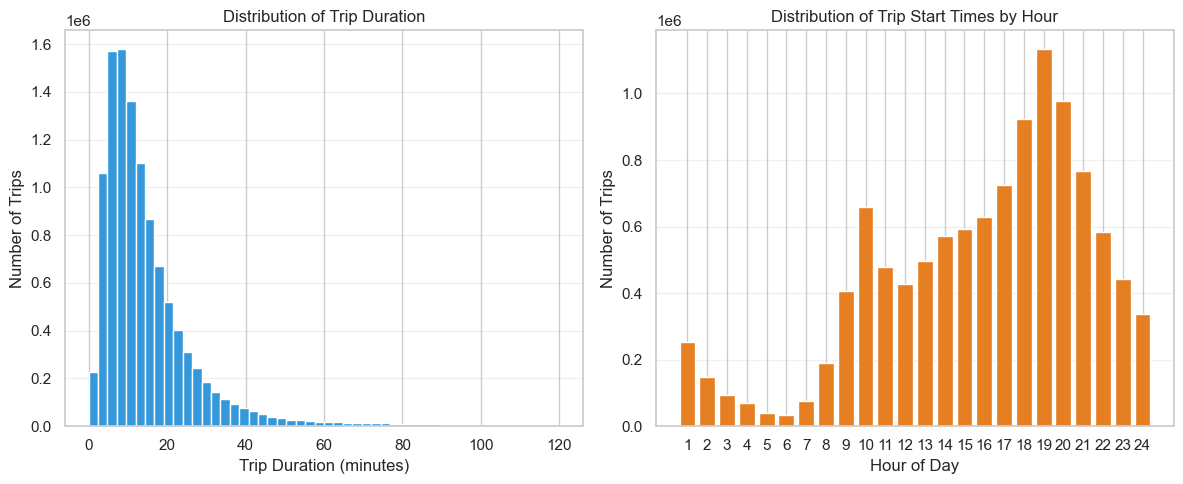

In [4]:
# Distribution of trip duration (in minutes)
trip_duration_minutes = trips['Trip Duration'] / 60.0

# Filter outliers for better visualization (keep trips under 2 hours)
trip_duration_filtered = trip_duration_minutes[trip_duration_minutes <= 120]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(trip_duration_filtered, bins=50, color='#3498db')
plt.title('Distribution of Trip Duration')
plt.xlabel('Trip Duration (minutes)')
plt.ylabel('Number of Trips')
plt.grid(axis='y', alpha=0.3)

# Distribution of trip start times by hour (base 1: 1 to 24)
plt.subplot(1, 2, 2)
# Base-1: shift hour from (0-23) --> (1-24)
hour_base1 = trips['hour'] + 1
hour_counts_base1 = hour_base1.value_counts().sort_index()
plt.bar(hour_counts_base1.index, hour_counts_base1.values, color='#e67e22')
plt.title('Distribution of Trip Start Times by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Trips')
plt.xticks(range(1, 25))
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

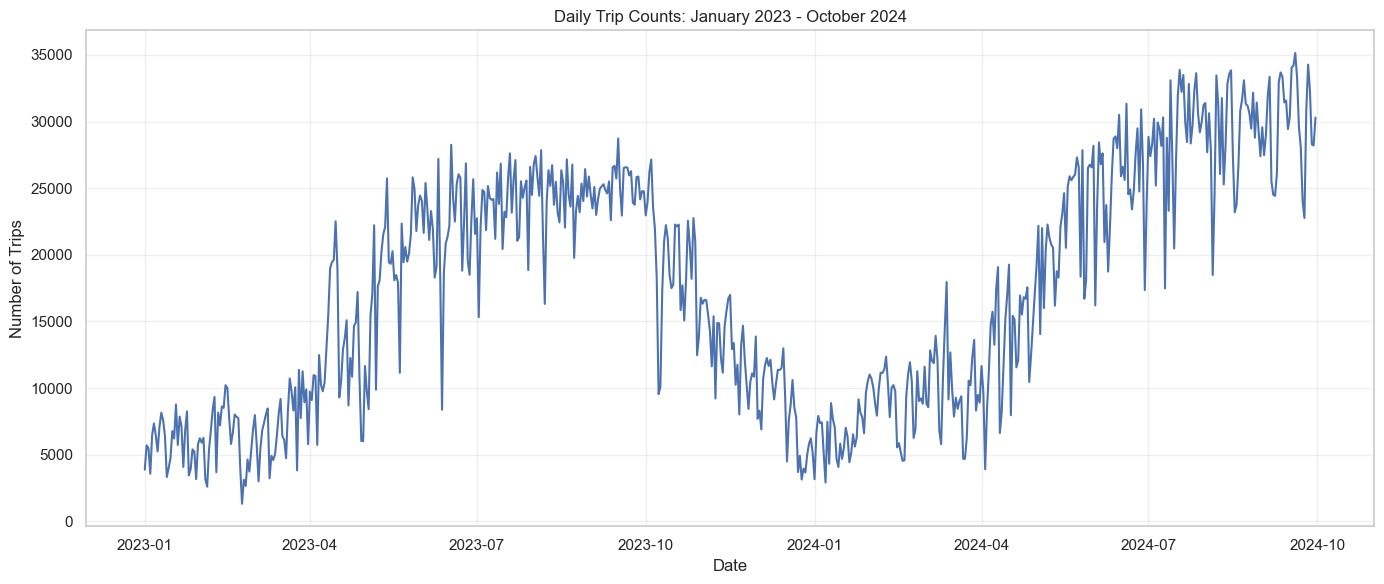

In [5]:
# Filter data for the period
mask = (trips['Start Time'] >= '2023-01-01') & (trips['Start Time'] < '2024-10-01')
period_data = trips[mask]

# Count trips per day
daily_counts = trips.groupby(period_data['Start Time'].dt.date).size()

# Visualize
daily_counts.plot(figsize=(14, 6))
plt.title('Daily Trip Counts: January 2023 - October 2024')
plt.xlabel('Date')
plt.ylabel('Number of Trips')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

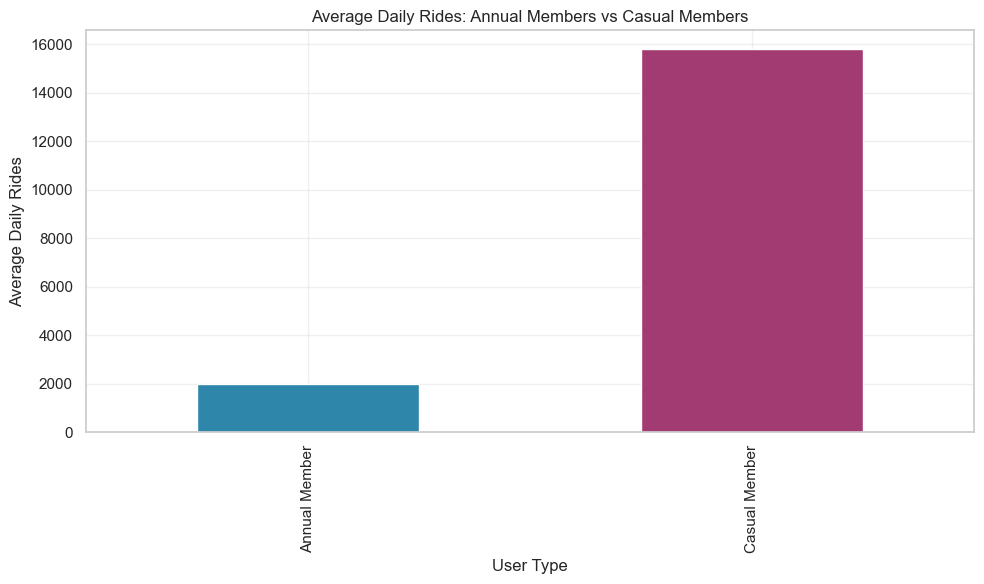

In [6]:
# Count daily rides by user type and calculate average daily rides
daily_rides = trips.groupby(['date', 'User Type']).size().reset_index(name='Rides')
avg_daily_rides = daily_rides.groupby('User Type')['Rides'].mean()

# Create bar plot
plt.figure(figsize=(10, 6))
avg_daily_rides.plot(kind='bar', color=['#2E86AB', '#A23B72'])
plt.title('Average Daily Rides: Annual Members vs Casual Members')
plt.xlabel('User Type')
plt.ylabel('Average Daily Rides')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [7]:
# Aggregations
# Daily trips by date and member type
daily_counts = trips.groupby(['date', 'User Type']).size().reset_index(name='rides')

# Average daily rides per month (by member type)
monthly_counts_daily_avg = (
    trips.groupby(['year_month', 'User Type', 'date']).size()
         .groupby(['year_month', 'User Type']).mean()
         .reset_index(name='avg_daily_rides')
)

monthly_counts_daily_avg['year'] = monthly_counts_daily_avg['year_month'].dt.year
monthly_counts_daily_avg['month'] = monthly_counts_daily_avg['year_month'].dt.month


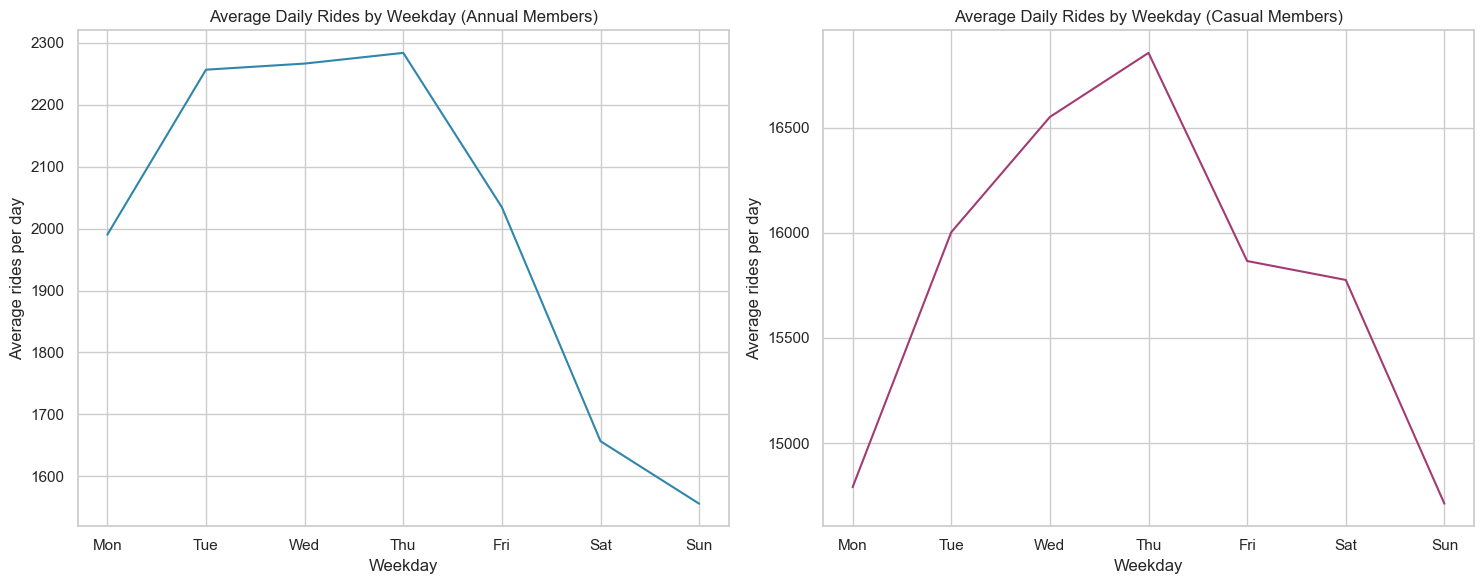

In [8]:
# Average daily rides in one week: Annual Members and Casual Members side by side

# Prepare data for Annual Members
annual_daily = daily_counts[daily_counts['User Type'] == 'Annual Member']
weekday_avg_annual = (
    annual_daily
    .assign(dayofweek=pd.to_datetime(annual_daily['date']).dt.dayofweek)
    .groupby('dayofweek')['rides']
    .mean()
    .reset_index()
)
weekday_avg_annual['dow_name'] = weekday_avg_annual['dayofweek'].map(_dow_map)
weekday_avg_annual = weekday_avg_annual.sort_values('dayofweek')

# Prepare data for Casual Members
casual_daily = daily_counts[daily_counts['User Type'] == 'Casual Member']
weekday_avg_casual = (
    casual_daily
    .assign(dayofweek=pd.to_datetime(casual_daily['date']).dt.dayofweek)
    .groupby('dayofweek')['rides']
    .mean()
    .reset_index()
)
weekday_avg_casual['dow_name'] = weekday_avg_casual['dayofweek'].map(_dow_map)
weekday_avg_casual = weekday_avg_casual.sort_values('dayofweek')

# Plot side by side using different y-axis scales
fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=False)  # Use sharey=False for different y-axis

sns.lineplot(data=weekday_avg_annual, x='dow_name', y='rides', ax=axes[0], color='#2E86AB')
axes[0].set_title('Average Daily Rides by Weekday (Annual Members)')
axes[0].set_xlabel('Weekday')
axes[0].set_ylabel('Average rides per day')

sns.lineplot(data=weekday_avg_casual, x='dow_name', y='rides', ax=axes[1], color='#A23B72')
axes[1].set_title('Average Daily Rides by Weekday (Casual Members)')
axes[1].set_xlabel('Weekday')
axes[1].set_ylabel('Average rides per day')

plt.tight_layout()
plt.show()


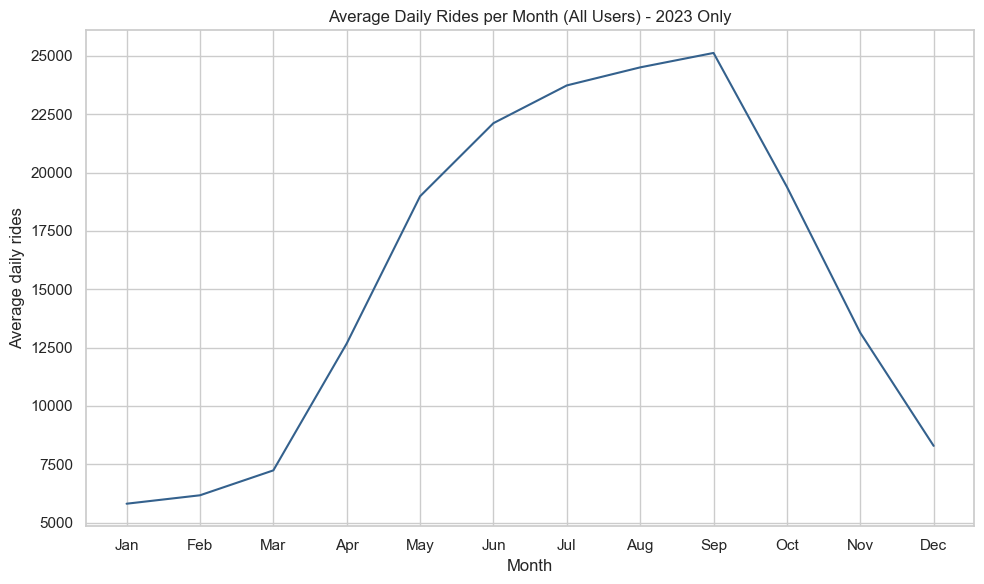

In [9]:
# Average monthly rides (average daily rides per month), all users combined, 2023 only
monthly_total_2023 = monthly_counts_daily_avg.query('year == 2023').groupby('year_month', as_index=False)['avg_daily_rides'].sum()
monthly_total_2023['month_name'] = monthly_total_2023['year_month'].dt.strftime('%b')

sns.lineplot(data=monthly_total_2023, x='month_name', y='avg_daily_rides', color='#34618D')
plt.title('Average Daily Rides per Month (All Users) - 2023 Only')
plt.xlabel('Month')
plt.ylabel('Average daily rides')
plt.tight_layout()
plt.show()


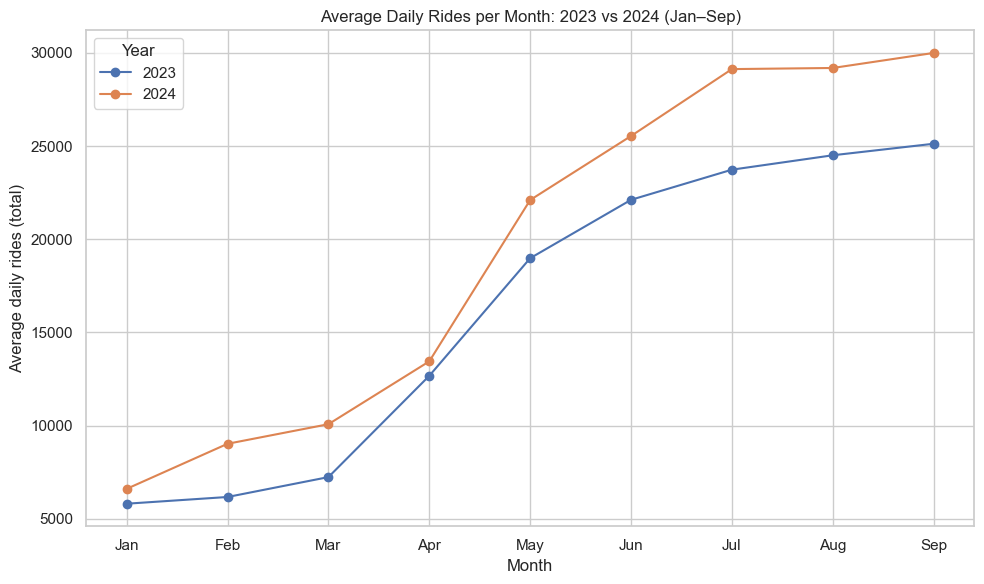

In [10]:
# Average monthly rides comparison: 2023 vs 2024 (Jan–Sep)
comp = monthly_counts_daily_avg.query('year in [2023, 2024] and month >= 1 and month <= 9')
comp_total = comp.groupby(['year', 'month'], as_index=False)['avg_daily_rides'].sum()

pivot = comp_total.pivot(index='month', columns='year', values='avg_daily_rides').sort_index()

ax = pivot.plot(marker='o')
ax.set_title('Average Daily Rides per Month: 2023 vs 2024 (Jan–Sep)')
ax.set_xlabel('Month')
ax.set_ylabel('Average daily rides (total)')
ax.set_xticks(range(1, 10))
ax.set_xticklabels([calendar.month_abbr[m] for m in range(1, 10)])
ax.legend(title='Year')
plt.tight_layout()
plt.show()


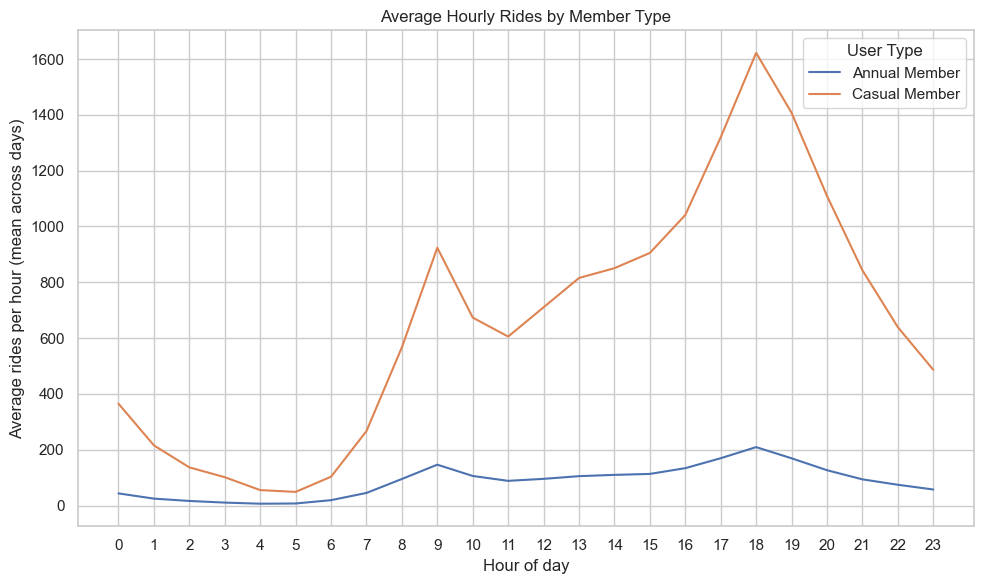

In [11]:
# Average hourly rides (mean across days) by member type
hourly_by_date = trips.groupby(['date', 'hour', 'User Type']).size().reset_index(name='rides')
hourly_counts = hourly_by_date.groupby(['hour', 'User Type'])['rides'].mean().reset_index()

sns.lineplot(data=hourly_counts, x='hour', y='rides', hue='User Type')
plt.title('Average Hourly Rides by Member Type')
plt.xlabel('Hour of day')
plt.ylabel('Average rides per hour (mean across days)')
plt.xticks(ticks=range(0, 24))
plt.legend(title='User Type')
plt.tight_layout()
plt.show()


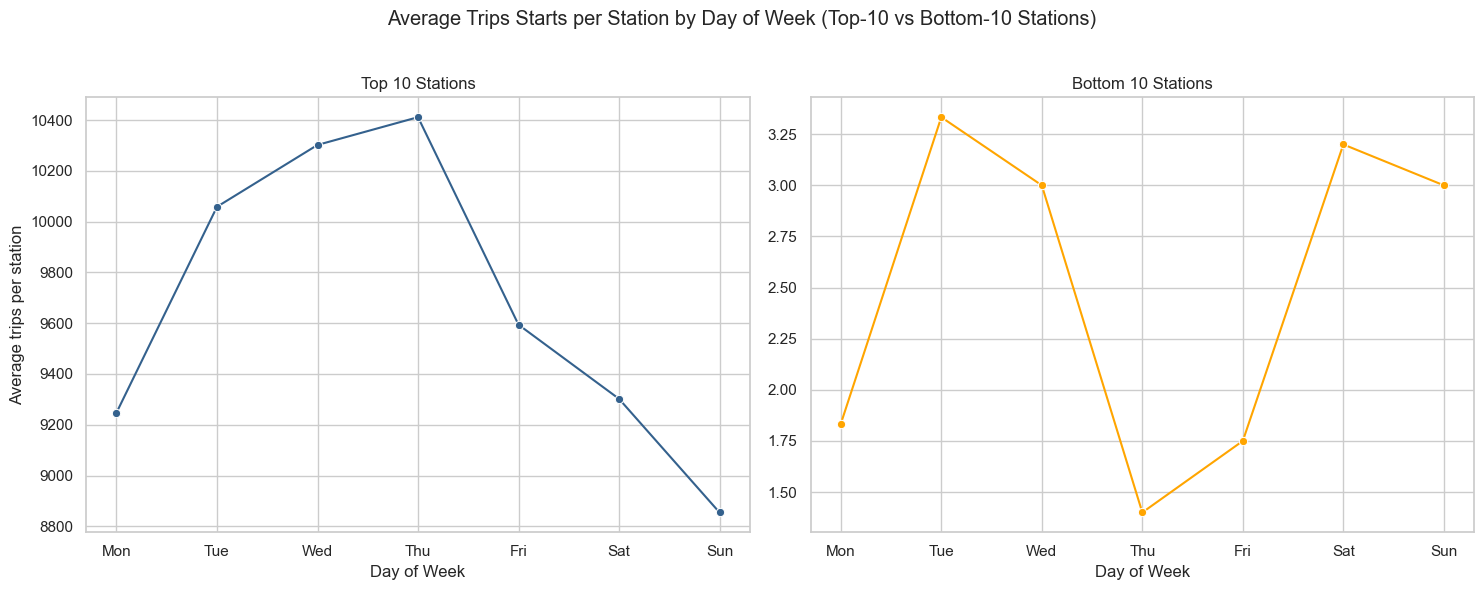

In [12]:
# Average trips per station (Top-10 vs Bottom-10) by day of week

# Calculate total trips per station for all available data
station_totals = trips.groupby('Start Station Id').size().reset_index(name='total_rides')
station_totals = station_totals[station_totals['total_rides'] > 0].sort_values('total_rides', ascending=False)

top_ids = station_totals.head(10)['Start Station Id']
bottom_ids = station_totals.tail(10)['Start Station Id']

# Group by station and day of week
station_dow = trips.groupby(['Start Station Id', 'dayofweek']).size().reset_index(name='rides')

# Compute average trips per station (per day-of-week) for busiest and least busy stations
top_stations_dow = (
    station_dow[station_dow['Start Station Id'].isin(top_ids)]
    .groupby('dayofweek', as_index=False)['rides']
    .mean()
    .rename(columns={'rides': 'top10_mean'})
)
top_stations_dow['dow_name'] = top_stations_dow['dayofweek'].map(_dow_map)

bottom_stations_dow = (
    station_dow[station_dow['Start Station Id'].isin(bottom_ids)]
    .groupby('dayofweek', as_index=False)['rides']
    .mean()
    .rename(columns={'rides': 'bottom10_mean'})
)
bottom_stations_dow['dow_name'] = bottom_stations_dow['dayofweek'].map(_dow_map)

# Plot the two lines side by side
fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=False)

sns.lineplot(data=top_stations_dow, x='dow_name', y='top10_mean', marker='o', ax=axes[0], color='#34618D')
axes[0].set_title('Top 10 Stations')
axes[0].set_xlabel('Day of Week')
axes[0].set_ylabel('Average trips per station')

sns.lineplot(data=bottom_stations_dow, x='dow_name', y='bottom10_mean', marker='o', ax=axes[1], color='orange')
axes[1].set_title('Bottom 10 Stations')
axes[1].set_xlabel('Day of Week')
axes[1].set_ylabel('')

plt.suptitle('Average Trips Starts per Station by Day of Week (Top-10 vs Bottom-10 Stations)')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


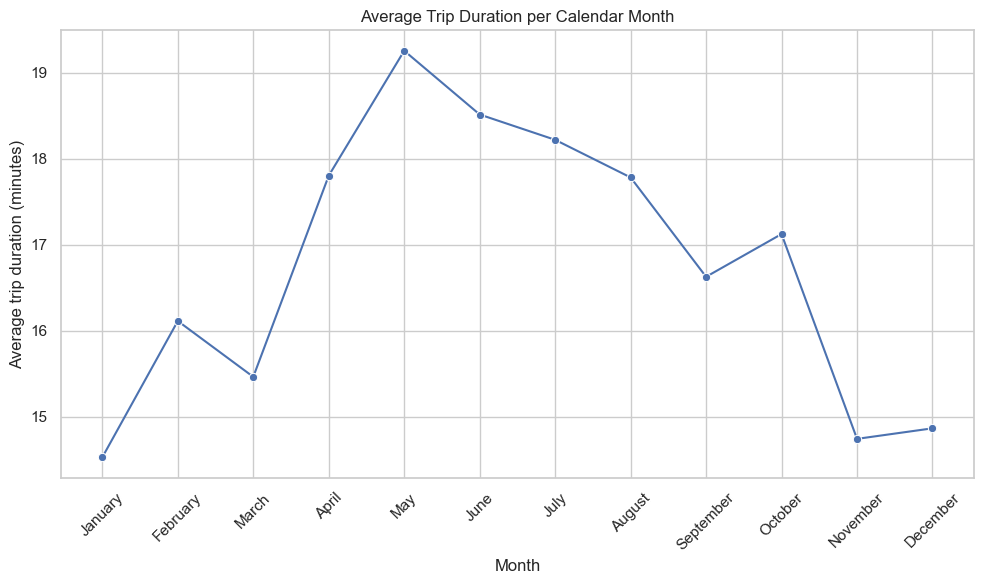

In [13]:
# Average trip duration by calendar month
trips['trip_minutes'] = trips['Trip Duration'] / 60.0
trips['month'] = trips['Start Time'].dt.month

monthly_duration = trips.groupby('month', as_index=False)['trip_minutes'].mean()

# Month names for tick labels (1-based index)
import calendar
monthly_duration['month_name'] = monthly_duration['month'].apply(lambda x: calendar.month_name[x])

sns.lineplot(data=monthly_duration, x='month_name', y='trip_minutes', marker='o')
plt.title('Average Trip Duration per Calendar Month')
plt.xlabel('Month')
plt.ylabel('Average trip duration (minutes)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


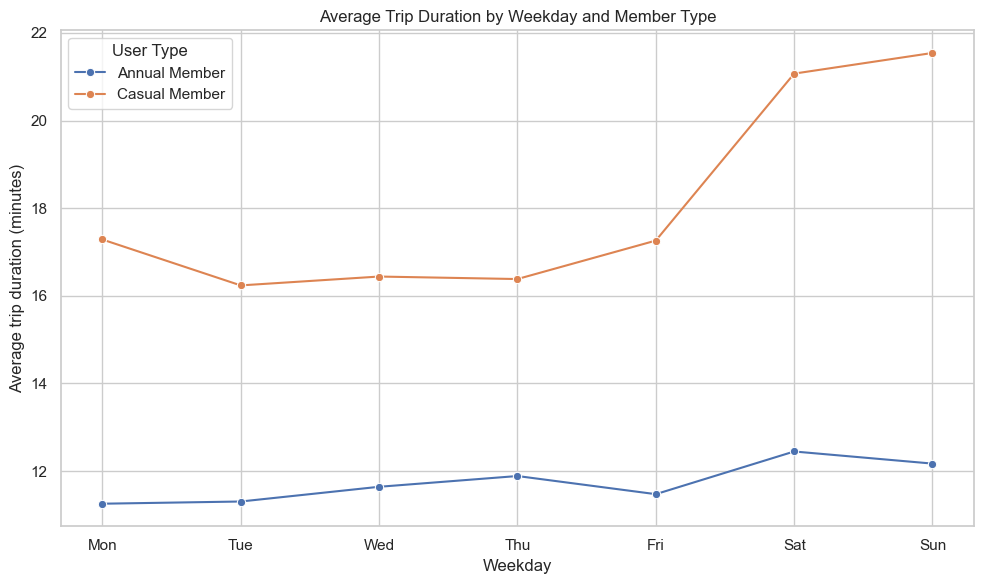

In [14]:
# Average trip duration by day of week
weekday_duration = trips.groupby(['dayofweek', 'User Type'], as_index=False)['trip_minutes'].mean()
weekday_duration['dow_name'] = weekday_duration['dayofweek'].map(_dow_map)
weekday_duration = weekday_duration.sort_values('dayofweek')

sns.lineplot(data=weekday_duration, x='dow_name', y='trip_minutes', hue='User Type', marker='o')
plt.title('Average Trip Duration by Weekday and Member Type')
plt.xlabel('Weekday')
plt.ylabel('Average trip duration (minutes)')
plt.legend(title='User Type')
plt.tight_layout()
plt.show()


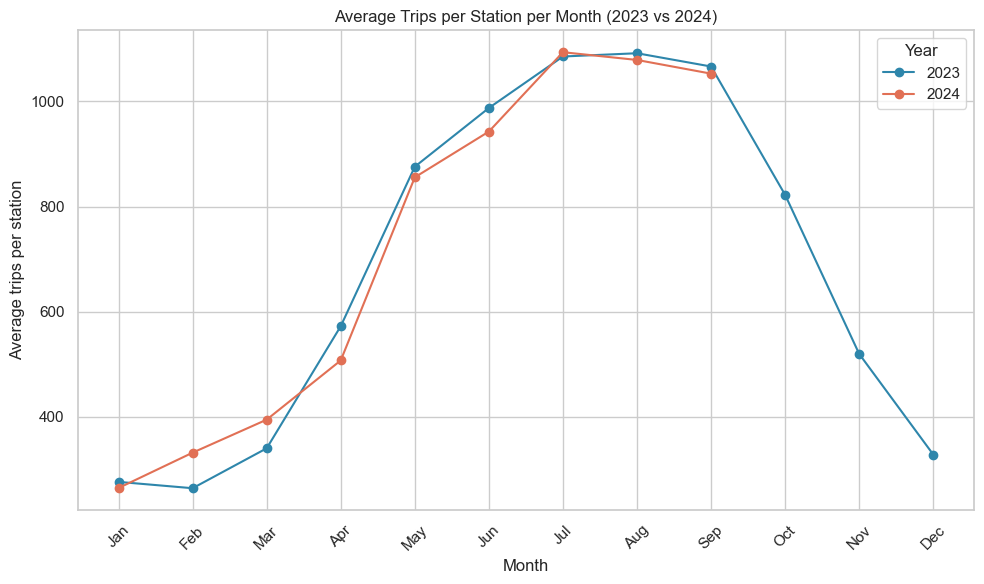

In [15]:
# Average trips per station per month, plotted separately for 2023 and 2024

# Calculate trips and stations per month
monthly_trips = trips.groupby('year_month').size().reset_index(name='total_trips')
monthly_stations = trips.groupby('year_month')['Start Station Id'].nunique().reset_index(name='num_stations')

avg_per_station = pd.merge(monthly_trips, monthly_stations, on='year_month', how='inner')
avg_per_station['avg_trips_per_station'] = avg_per_station['total_trips'] / avg_per_station['num_stations']

# Exclude any erroneous future month if present
avg_per_station = avg_per_station[avg_per_station['year_month'] != '2024-10']

# Extract year and month for plotting
avg_per_station['year'] = avg_per_station['year_month'].dt.year
avg_per_station['month'] = avg_per_station['year_month'].dt.month

# Short month names (1-based index)
month_abbr = [
    '', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'
]
months = list(range(1, 13))
month_names = [month_abbr[i] for i in months]

# Prepare data for 2023 and 2024
data_2023 = avg_per_station[avg_per_station['year'] == 2023]
data_2024 = avg_per_station[avg_per_station['year'] == 2024]

fig, ax = plt.subplots(figsize=(10,6))

# Plot 2023
ax.plot(data_2023['month'], data_2023['avg_trips_per_station'], marker='o', color='#2E86AB', label='2023')

# Plot 2024
ax.plot(data_2024['month'], data_2024['avg_trips_per_station'], marker='o', color='#E17055', label='2024')

ax.set_title('Average Trips per Station per Month (2023 vs 2024)')
ax.set_xlabel('Month')
ax.set_ylabel('Average trips per station')
ax.set_xticks(months)
ax.set_xticklabels(month_names, rotation=45)
ax.legend(title='Year')
plt.tight_layout()
plt.show()

## Weather Data with Bike Trips Data

In [16]:
# Weather: parse timestamps and construct hourly key (guaranteed hourly, guaranteed headers)
weather = weather_data.copy()

weather['Date/Time'] = pd.to_datetime(weather['Date/Time'], utc=True)

# # Hour bucket key for join
weather['hour_ts'] = weather['Date/Time'].dt.floor('h').dt.tz_convert('America/Toronto')

# Select columns
weather_hourly = weather[['hour_ts', 'Temp (°C)', 'Rel Hum (%)', 'Precip. Amount (mm)', 'Wind Spd (km/h)', 'Visibility (km)', 'Weather']]
weather_hourly.head()


,hour_ts,Temp (°C),Rel Hum (%),Precip. Amount (mm),Wind Spd (km/h),Visibility (km),Weather
0,2024-06-01 00:00:00-04:00,13.6,83.0,0.0,8.0,16.1,NaN
1,2024-06-01 01:00:00-04:00,13.9,80.0,0.0,5.0,16.1,NaN
2,2024-06-01 02:00:00-04:00,13.9,78.0,0.0,5.0,16.1,NaN
3,2024-06-01 03:00:00-04:00,13.3,85.0,0.0,9.0,16.1,NaN
4,2024-06-01 04:00:00-04:00,13.4,81.0,0.0,4.0,16.1,NaN


In [17]:
# Trips: aggregate to hourly (Toronto tz)
trips_copy = trips_data.copy()

trips_copy['hour_ts'] = pd.to_datetime(trips_copy['Start Time']).dt.floor('h').dt.tz_convert('America/Toronto')

trips_hourly = trips_copy.groupby('hour_ts').size().reset_index(name='trips_per_hour')

trips_hourly.head()


,hour_ts,trips_per_hour
0,2023-01-01 00:00:00-05:00,197
1,2023-01-01 01:00:00-05:00,290
2,2023-01-01 02:00:00-05:00,281
3,2023-01-01 03:00:00-05:00,240
4,2023-01-01 04:00:00-05:00,125


In [18]:
# Join hourly trips with weather on the hour key
hourly = trips_hourly.merge(weather_hourly, on='hour_ts', how='inner')
hourly.head()


,hour_ts,trips_per_hour,Temp (°C),Rel Hum (%),Precip. Amount (mm),Wind Spd (km/h),Visibility (km),Weather
0,2023-01-01 00:00:00-05:00,197,4.0,83.0,0.0,11.0,16.1,NaN
1,2023-01-01 01:00:00-05:00,290,3.9,87.0,0.0,18.0,16.1,NaN
2,2023-01-01 02:00:00-05:00,281,3.7,87.0,0.0,17.0,16.1,NaN
3,2023-01-01 03:00:00-05:00,240,3.5,87.0,0.0,17.0,16.1,NaN
4,2023-01-01 04:00:00-05:00,125,4.4,79.0,0.0,21.0,16.1,NaN


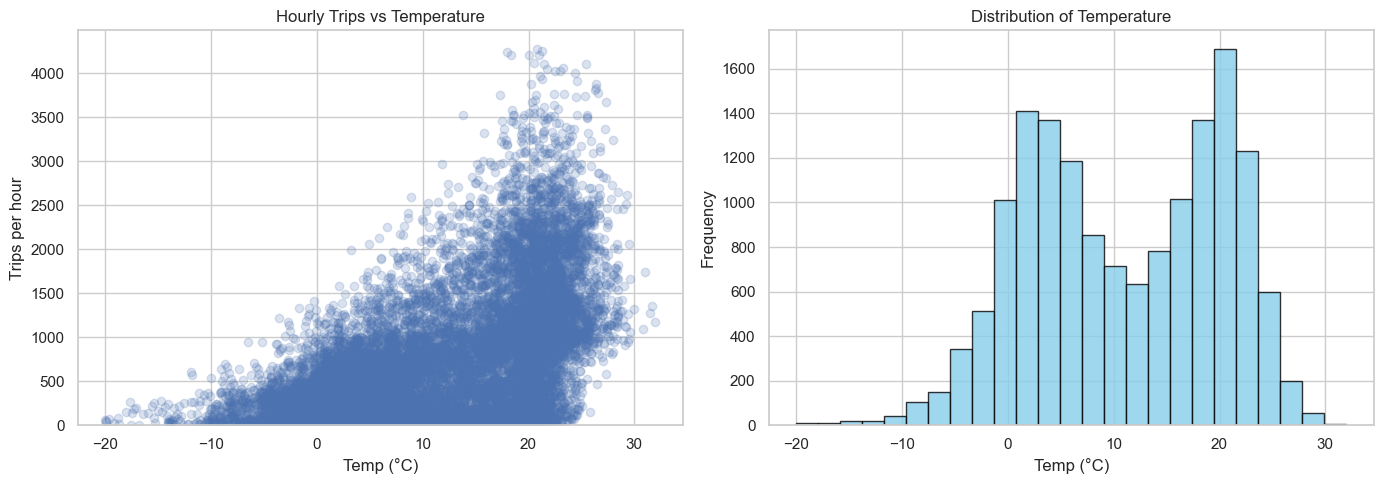

In [19]:
# Trips vs Temperature (scatter-only, y-axis starts at 0) + Temperature distribution histogram side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot
axes[0].scatter(hourly['Temp (°C)'], hourly['trips_per_hour'], alpha=0.2)
axes[0].set_title('Hourly Trips vs Temperature')
axes[0].set_xlabel('Temp (°C)')
axes[0].set_ylabel('Trips per hour')
axes[0].set_ylim(bottom=0)

# Histogram
axes[1].hist(hourly['Temp (°C)'].dropna(), bins=25, color='skyblue', edgecolor='black', alpha=0.8)
axes[1].set_title('Distribution of Temperature')
axes[1].set_xlabel('Temp (°C)')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()



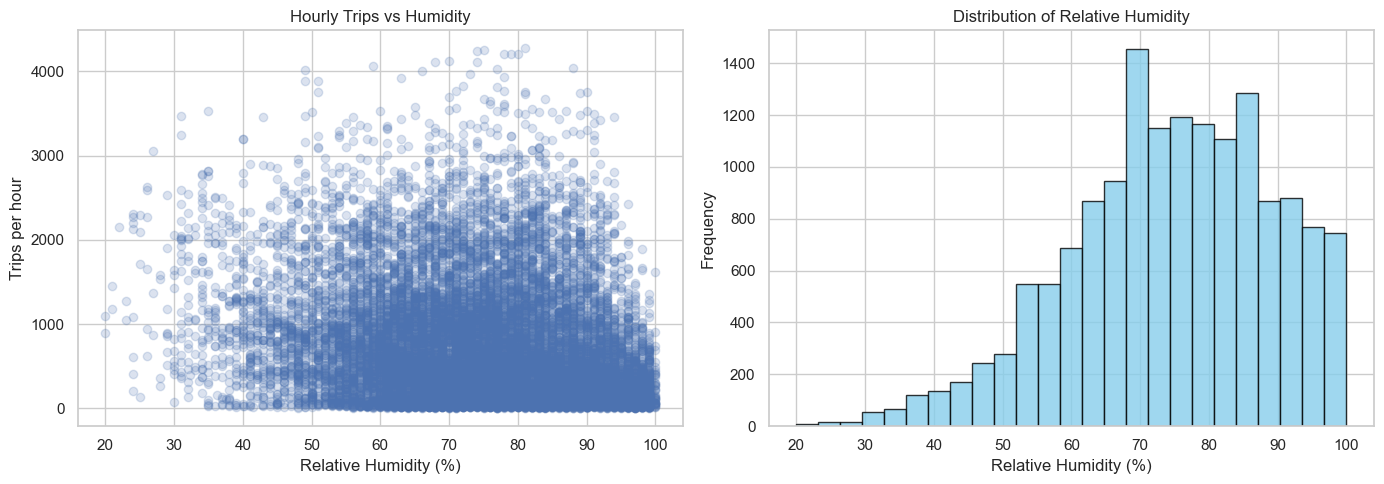

In [20]:
# Trips vs Humidity (scatter + LOWESS) and Histogram of Humidity side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot
axes[0].scatter(hourly['Rel Hum (%)'], hourly['trips_per_hour'], alpha=0.2)
axes[0].set_title('Hourly Trips vs Humidity')
axes[0].set_xlabel('Relative Humidity (%)')
axes[0].set_ylabel('Trips per hour')

# Histogram
axes[1].hist(hourly['Rel Hum (%)'].dropna(), bins=25, color='skyblue', edgecolor='black', alpha=0.8)
axes[1].set_title('Distribution of Relative Humidity')
axes[1].set_xlabel('Relative Humidity (%)')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


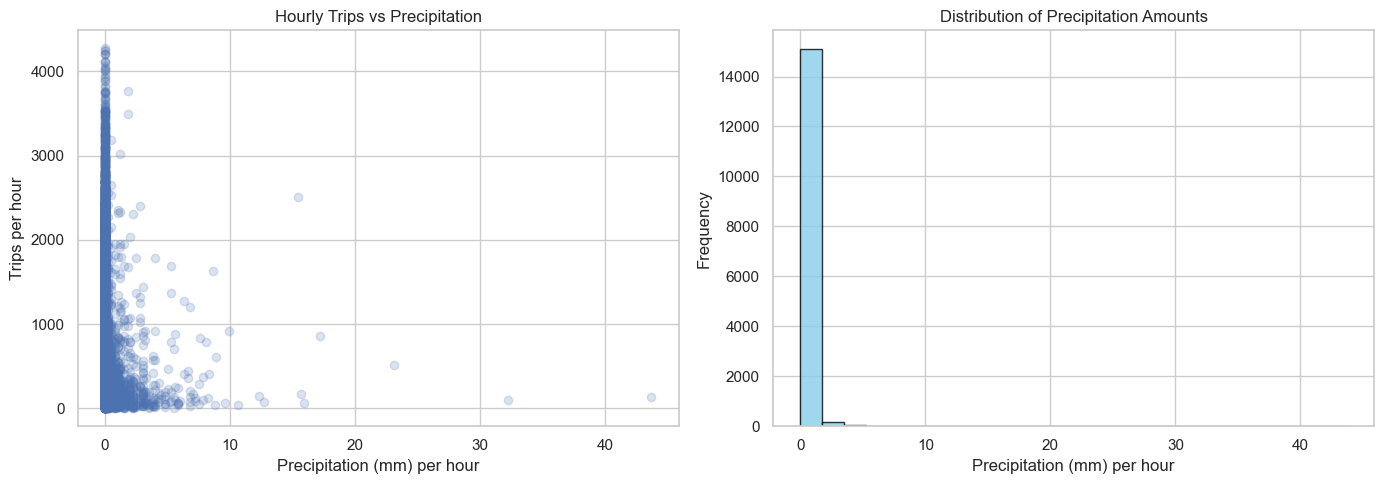

In [21]:
# Trips vs Precipitation (scatter + LOWESS) and Histogram of Precipitation Amounts side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot
axes[0].scatter(hourly['Precip. Amount (mm)'], hourly['trips_per_hour'], alpha=0.2)
axes[0].set_title('Hourly Trips vs Precipitation')
axes[0].set_xlabel('Precipitation (mm) per hour')
axes[0].set_ylabel('Trips per hour')

# Histogram
axes[1].hist(hourly['Precip. Amount (mm)'].dropna(), bins=25, color='skyblue', edgecolor='black', alpha=0.8)
axes[1].set_title('Distribution of Precipitation Amounts')
axes[1].set_xlabel('Precipitation (mm) per hour')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()



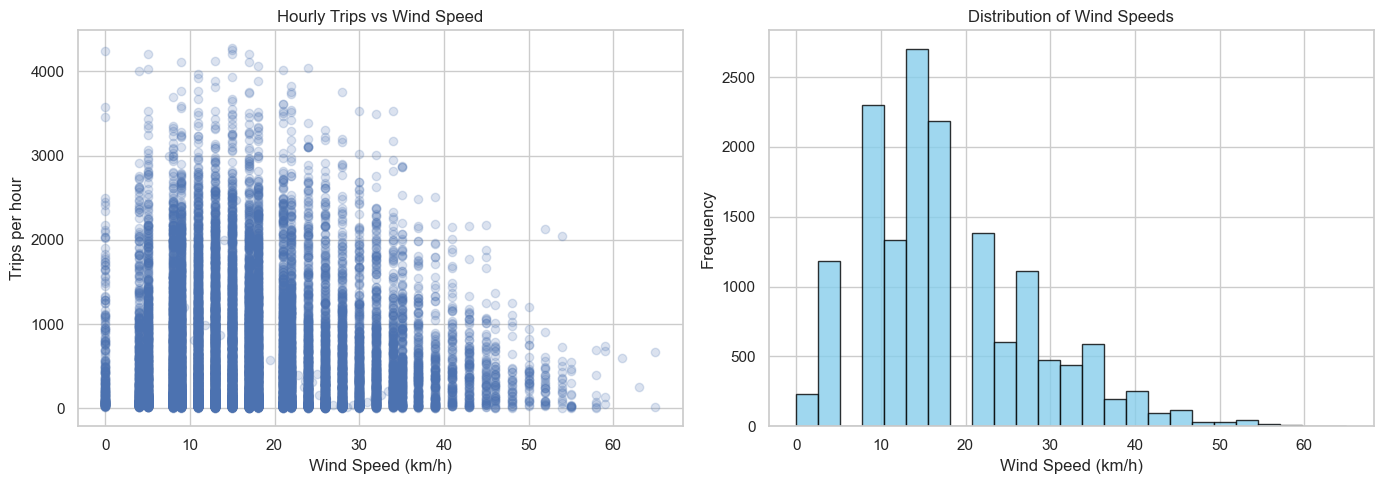

In [22]:
# Trips vs Wind Speed (scatter + LOWESS) and Histogram of Wind Speeds side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot
axes[0].scatter(hourly['Wind Spd (km/h)'], hourly['trips_per_hour'], alpha=0.2)
axes[0].set_title('Hourly Trips vs Wind Speed')
axes[0].set_xlabel('Wind Speed (km/h)')
axes[0].set_ylabel('Trips per hour')

# Histogram
axes[1].hist(hourly['Wind Spd (km/h)'].dropna(), bins=25, color='skyblue', edgecolor='black', alpha=0.8)
axes[1].set_title('Distribution of Wind Speeds')
axes[1].set_xlabel('Wind Speed (km/h)')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


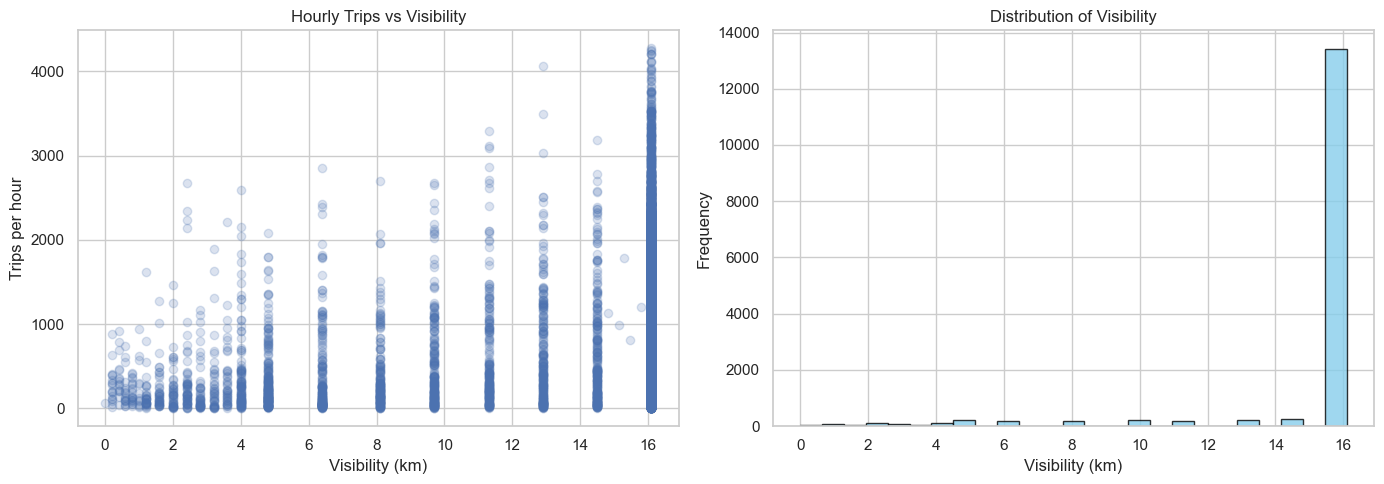

In [23]:
# Trips vs Visibility (scatter) and Distribution of Visibility (histogram) side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot: Trips vs Visibility
axes[0].scatter(hourly['Visibility (km)'], hourly['trips_per_hour'], alpha=0.2)
axes[0].set_title('Hourly Trips vs Visibility')
axes[0].set_xlabel('Visibility (km)')
axes[0].set_ylabel('Trips per hour')

# Histogram: Distribution of Visibility
axes[1].hist(hourly['Visibility (km)'].dropna(), bins=25, color='skyblue', edgecolor='black', alpha=0.8)
axes[1].set_title('Distribution of Visibility')
axes[1].set_xlabel('Visibility (km)')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()
